In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import os
from pathlib import Path
import json

import sys

sys.path.append("scripts")

import utils
import distclassipy as dcpy

cd = dcpy.Distance()

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

classification_letter = "c"
classification_problem = settings_dict["classification_problem"][classification_letter]
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]
results_subfolder = f"{classification_letter}. {classification_problem}"
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

In [3]:
#check_estimator(dcpy.DistanceMetricClassifier())  # passes

In [4]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

In [5]:
# Remove manually selected 'bad' features
with open(os.path.join("results", results_subfolder, "drop_features.txt")) as f:
    bad_features = json.load(f)  # manually selected

X_df_FULL = X_df_FULL.drop(bad_features, axis=1)

print(X_df_FULL.shape[1])

31


In [6]:
# bad_features

In [7]:
# Keep only current classes
cl_keep_str = "_".join(classes_to_keep)

y_df = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
X_df = X_df_FULL.loc[y_df.index]
X = X_df.to_numpy()
y = y_df.to_numpy().ravel()

In [8]:
metric = "canberra"

In [9]:
metric_str = utils.get_metric_name(metric)

# Feature Importance via Feature Permutation

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size=0.33, stratify=y, random_state=settings_dict["seed_choice"]
)

In [10]:
from sklearn.feature_selection import RFE

In [11]:
locpath = os.path.join("results", results_subfolder, "distclassipy", metric_str)
sfs_df = pd.read_csv(os.path.join(locpath, "sfs_allfeatures.csv"), index_col=0)
sfs_feats_idx, sfs_feats = utils.load_best_features(sfs_df)
n_select = len(sfs_feats)

print(f"We will be selecting {n_select} features")

We will be selecting 3 features


In [12]:
lcdc = dcpy.DistanceMetricClassifier(
    metric=metric, calculate_kde=False, calculate_1d_dist=False,
    calculate_importances=True
)

lcdc.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

# lcdc.feature_importances_

DistanceMetricClassifier(calculate_1d_dist=False, calculate_importances=True,
                         calculate_kde=False, metric='canberra')

In [13]:
rfe = RFE(estimator=lcdc, n_features_to_select=n_select, step=1, 
          verbose=1)

rfe.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

ranking = rfe.ranking_
# print("Ranking of features:", ranking)

Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features

In [14]:
rfe.ranking_

array([23,  2, 13,  1,  1, 21,  8, 17, 14,  6, 11,  9, 16, 20, 27, 15, 28,
       29, 19, 22,  1, 25,  5,  7,  4, 10, 26, 24, 12,  3, 18])

In [15]:
rfe_feats = X_df.columns[rfe.ranking_ == 1].to_numpy()

In [16]:
lcdc_sfs = dcpy.DistanceMetricClassifier(
    metric=metric, calculate_kde=False, calculate_1d_dist=False
)

lcdc_rfe = dcpy.DistanceMetricClassifier(
    metric=metric, calculate_kde=False, calculate_1d_dist=False
)

In [17]:
y_pred_sfs = cross_val_predict(
    lcdc_sfs, 
    X_df.loc[:,sfs_feats].to_numpy(), 
    y_df.to_numpy().ravel()
)

y_pred_rfe = cross_val_predict(
    lcdc_rfe, 
    X_df.loc[:,rfe_feats].to_numpy(), 
    y_df.to_numpy().ravel()
)


In [18]:
acc_sfs = accuracy_score(y, y_pred_sfs)
f1score_sfs = f1_score(y, y_pred_sfs, average="macro")
matthew_coef_sfs = matthews_corrcoef(y, y_pred_sfs)

acc_rfe = accuracy_score(y, y_pred_rfe)
f1score_rfe = f1_score(y, y_pred_rfe, average="macro")
matthew_coef_rfe = matthews_corrcoef(y, y_pred_rfe)

Top 3 features as per SFS:
['Period_band_r', 'Harmonics_mag_1_r', 'Harmonics_phase_2_r']


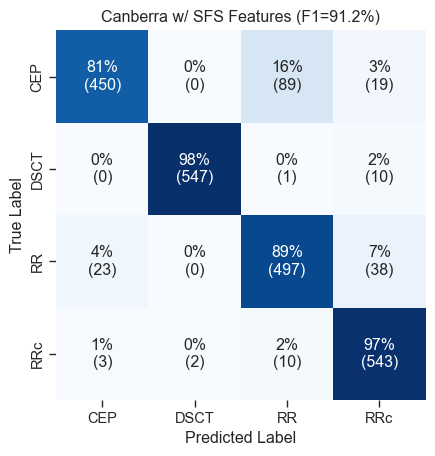

In [19]:
print(f"Top {n_select} features as per SFS:\n{sfs_feats}")
ax = utils.plot_cm(y_true=y, y_pred=y_pred_sfs)
ax.set_title(f"{metric_str.title()} w/ SFS Features (F1={f1score_sfs:.1%})")
plt.show()

Top 3 features as per RFE:
['Period_band_r' 'GP_DRW_tau_r' 'Gskew_r']


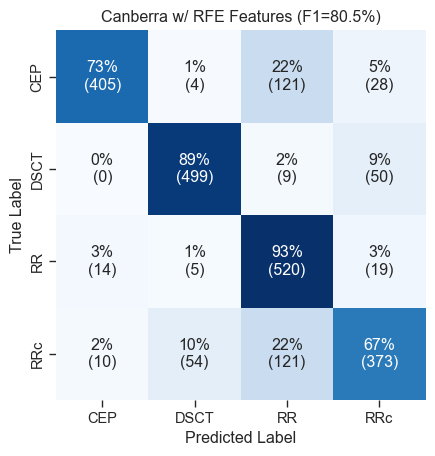

In [20]:
print(f"Top {n_select} features as per RFE:\n{rfe_feats}")
ax = utils.plot_cm(y_true=y, y_pred=y_pred_rfe)
ax.set_title(f"{metric_str.title()} w/ RFE Features (F1={f1score_rfe:.1%})")
plt.show()